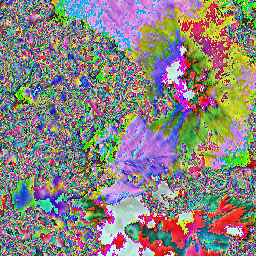

In [33]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms


with open(rf'C:\Users\andre\PycharmProjects\WakeClassificationDoneGood\datasets\THRAWS\Test\event\Fuego_00_G3_(768, 0, 1024, 256)_A674.77.pkl', 'rb') as f:
    data = pickle.load(f)
    image = Image.fromarray(data.astype('uint8'), 'RGB')

image



In [48]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import pytorch_lightning as pl
import pandas as pd
import os
import numpy as np


def load_stack_by_index(stack_folder, index):
    # Construct the filename based on the index
    filename = f"stack_{index}.npy"

    # Join the destination folder path with the filename
    file_path = os.path.join(stack_folder, filename)

    # Load the stack using numpy
    stack = np.load(file_path)

    return stack

class xAIWakesDataset(Dataset):
    def __init__(self, csv_dir, root_dir, transform=None):
        super().__init__()
        self.annotations = pd.read_csv(csv_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)  # 269 images

    def __getitem__(self, index):
        # con gli stack .npy
        image = load_stack_by_index(self.root_dir, index)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        image = image.permute(1, 0, 2)
        return (image, y_label)


class xAIWakesDataModule(pl.LightningDataModule):
    def __init__(self, csv_file, root_dir, batch_size=8, num_workers=1, transform=None):
        super().__init__()
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def prepare_data(self):
        # Left empty as data is already downloaded and preprocessed
        pass

    def setup(self, stage):
        my_ds = xAIWakesDataset(self.csv_file, self.root_dir, self.transform)
        self.train_ds, self.val_ds, self.test_ds = random_split(my_ds, [0.6, 0.2, 0.2])
        # my_predict_ds = xAIWakesDataset(rf"C:\\path_to_csv", root_dir)
        # self.predict_ds = my_predict_ds
        self.predict_ds = my_ds

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,
        )



In [49]:
compose_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: x.view(-1, 256, 256))  # Reshaping to CxHxW
    ])

dataset = SentinelDataset(
    root_dir=rf'C:\Users\andre\PycharmProjects\WakeClassificationDoneGood\datasets\THRAWS',
    transform=compose_transform,
    )

In [50]:
data_module = SentinelDataModule(root_dir=rf'C:\Users\andre\PycharmProjects\WakeClassificationDoneGood\datasets\THRAWS')

In [52]:
# Load one image from the dataset
image, label = dataset[0]

# Print the shape of the image
print("Shape of the image:", image.shape)
image.shape[0]

Shape of the image: torch.Size([3, 256, 256])


3